# Add stratigraphy from GeoTOP to CPT data

This example shows how stratigraphic layer boundaries from GeoTOP can easily be added to CPT data. This way, CPT parameters can easily be aggregated to get averages for geological units. For this example we are going to use a selection of CPTs in the area of the Utrecht Science Park (USP).

We will first import the relevant modules and plot the locations of the CPTs in the [`CptCollection`](../api_reference/cpt_collection.rst).

In [1]:
# import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

import geost
from geost.analysis.combine import add_voxelmodel_variable
from geost.bro import GeoTop
from geost.bro.bro_geotop import StratGeotop

cpts = geost.data.cpts_usp()
cpts.header.explore(style_kwds=dict(color="red", weight=6))

## Adding information from a voxelmodel
Any information from voxelmodels can be added. For this example we show how to add the stratigraphy from GeoTOP to the CPTs. First we read GeoTOP directly from the OpenDaP server for the USP area.

In [2]:
geotop = GeoTop.from_opendap(data_vars=["strat"], bbox=cpts.header.total_bounds)
print(geotop)

c:\Users\onselen\Development\geost\.pixi\envs\default\Lib\site-packages\pydap\handlers\dap.py:143: UserWarning: PyDAP was unable to determine the DAP protocol defaulting to DAP2. DAP2 is consider legacy and may result in slower responses. 
Consider replacing `http` in your `url` with either `dap2` or `dap4` to specify the DAP protocol (e.g. `dap2://<data_url>` or `dap4://<data_url>`).  For more 
information, go to https://www.opendap.org/faq-page.
  warnings.warn(


GeoTop
Data variables:
    strat    (y, x, z) float32 260kB dask.array<chunksize=(13, 16, 76), meta=np.ndarray>
Dimensions: {'y': 13, 'x': 16, 'z': 313}
Resolution (y, x, z): (100.0, 100.0, 0.5)


As you can see, this prints a [`GeoTop`](../api_reference/bro_geotop.rst) instance along with the dimensions and resolution of GeoTOP. We can use this GeoTop instance to add the variable "strat" to the CPT data. This adds a column "strat" to the data object of the [`CptCollection`](../api_reference/cpt_collection.rst). First, we must create a "depth" column in the CPT data because this is expected to be present in the data. We can use the column "penetration_length" for this. Below we add the variable and print the resulting column:

In [3]:
cpts.data["depth"] = cpts.data["depth"]
cpts = add_voxelmodel_variable(cpts, geotop, "strat")
print(cpts.data["strat"])

1        2010.0
2        2010.0
3        2010.0
4        2010.0
5        2010.0
          ...  
73974    3100.0
73975    3100.0
73976    3100.0
73977    3100.0
73978    3100.0
Name: strat, Length: 73368, dtype: float32


C:\Users\onselen\Development\geost\geost\validation\validate.py:47: ValidationWarning: 
Validation dropped 42 row(s) for schema 'Discrete data non-inclined'.
Dropped indices: [0, 247, 504, 761, 1018, 1275, 5086, 6114, 6371, 6628, 6885, 7400, 7657, 8952, 9468, 9984, 10500, 12540, 12798, 13031, 13265, 13523, 13781, 14039, 14299, 14557, 14816, 39005, 40013, 40922, 41935, 44146, 45372, 49304, 52989, 61534, 62594, 67722, 68733, 72066, 72527, 73424]

  warnings.warn(


Note that some of the resulting values are "NaN" which occurs when a CPT falls outside of the 3D model extent. In this case, some CPTs are deeper than the maximum depth of GeoTOP. Now we could easily aggregate any CPT parameter according to the new "strat" variable. For example, make a boxplot of the average cone resistance ("qc"):

Text(0, 0.5, 'Cone resistance [MPa]')

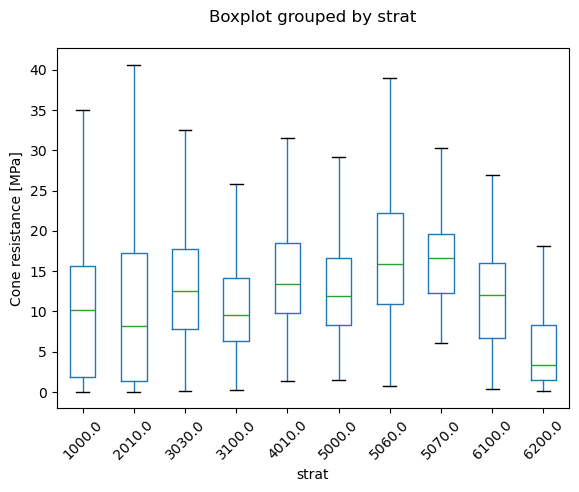

In [4]:
fig, ax = plt.subplots()
cpts.data.boxplot(
    ax=ax, column="cone_resistance", by="strat", grid=False, showfliers=False
)
ax.tick_params(axis="x", rotation=45)
ax.set_title("")
ax.set_ylabel("Cone resistance [MPa]")

Each number on the x-axis represents a geological unit. However, these numbers are off course not really intuitive and knowing the corresponding geological unit is hard. GeoST provides the [`StratGeotop`](../api_reference/geotop_selection.rst) class which makes it easy to select desired stratigraphic units with or relabel the unit numbers in the plot above into more meaningfull names.

First, we select all the units that have been merged with the CPT data:

In [5]:
units = StratGeotop.select_values(cpts.data["strat"].unique())
units

[<HoloceneUnits.EC: 2010>,
 <ChannelBeltUnits.BEC: 6100>,
 <ChannelBeltUnits.CEC: 6200>,
 <OlderUnits.BXWISIKO: 3030>,
 <OlderUnits.BX: 3100>,
 <OlderUnits.KRBXDE: 4010>,
 <OlderUnits.DR: 5000>,
 <OlderUnits.UR: 5060>,
 <OlderUnits.ST: 5070>,
 <AntropogenicUnits.AAOP: 1000>]

This returns a list of enum types for each unit. An enum contains a "name" with corresponding "value". Now, we can make a dictionary with both and replace the numbers with the names in the "strat" column. Let's print the result and plot the figure again:

1        EC
2        EC
3        EC
4        EC
5        EC
         ..
73974    BX
73975    BX
73976    BX
73977    BX
73978    BX
Name: strat, Length: 73368, dtype: object


Text(0, 0.5, 'Cone resistance [MPa]')

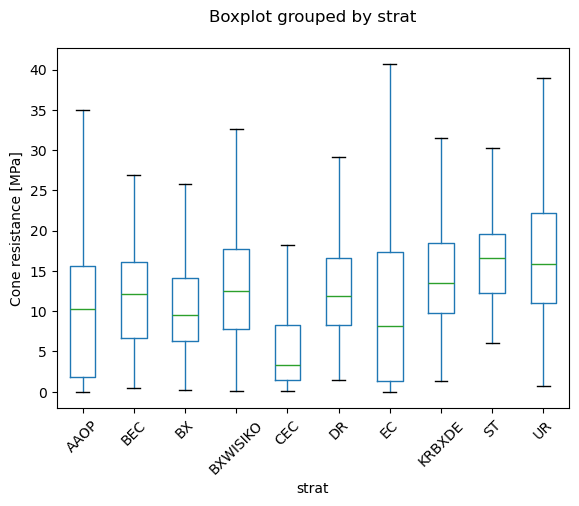

In [6]:
replace_dict = {unit.value: unit.name for unit in units}
cpts.data.replace({"strat": replace_dict}, inplace=True)
print(cpts.data["strat"])

fig, ax = plt.subplots()
cpts.data.boxplot(
    ax=ax, column="cone_resistance", by="strat", grid=False, showfliers=False
)
ax.tick_params(axis="x", rotation=45)
ax.set_title("")
ax.set_ylabel("Cone resistance [MPa]")

The x-axis in the plot now has some more meaningful abbreviations for geological units which can be found in the [stratigraphic nomenclature](https://www.dinoloket.nl/stratigrafische-nomenclator/boven-noordzee-groep). Most units belong to the "Boven-Noordzee Groep" (prefix "NU"). For example, the unit "EC" in the plot with the corresponding code can be found [here](https://www.dinoloket.nl/stratigrafische-nomenclator/formatie-van-echteld).

The [`StratGeotop`](../api_reference/geotop_selection.rst) class can be used for all sorts of selections and groupings a user would like for further analyses.